# A Bayesian Model for News Reporting {-}

*Nicholas Lines*

# Environment Setup

In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import arviz as az
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import graphviz
import os
import pymc3 as pm
from pymc3 import Model, Normal, HalfNormal, Bernoulli, Deterministic, Uniform
from pymc3 import find_MAP

In [3]:
import scipy.stats as st

In [4]:
from tqdm.notebook import tqdm

# Experiment

In [233]:
I = 20
T = 100
hidden_delta = np.random.uniform(high=0.5)
hidden_beta = np.random.uniform(size=I)
hidden_epsilon = np.random.uniform(size=I)
hidden_f_array = np.random.uniform(size=(T))<= hidden_delta
l = hidden_f_array.shape[0]
hidden_f = np.concatenate([hidden_f_array.reshape((l,1))]*I,axis=1)
hidden_alpha = np.random.uniform(size=(T,I)) <= hidden_beta.reshape(1,-1)
hidden_tau   = np.random.uniform(size=(T,I)) <= hidden_epsilon.reshape(1,-1)
hidden_r     = np.random.uniform(size=(T,I)) <= 0.5
observed_data = (hidden_tau*(hidden_alpha * hidden_f + (1-hidden_alpha)*hidden_r) + 2*(1-hidden_tau))

In [234]:
observed_data.shape

(100, 20)

In [236]:
reporter_model = Model()
with reporter_model:
    delta = Uniform(name="delta", lower=0, upper=1)
    f = Bernoulli(name="f", p=delta,shape=T)
    beta = Uniform(name="beta", lower=0, upper=1, shape=I)
    epsilon = Uniform(name="epsilon", lower=0, upper=1, shape=I)
    alpha = Bernoulli(name="alpha", p=beta,shape=(T,I))
    tau = Bernoulli(name="tau", p=epsilon,shape=(T,I))
    r = Bernoulli(name="r", p=0.5,shape=(T,I))
    o = [Deterministic("o_"+str(t), tau[t,:] * (alpha[t,:] * f[t] + (1-alpha[t,:])*r[t,:]) + 2*(1-tau[t,:])) for t in range(T)]
    X = [Normal("X_"+str(t),mu=o[t],sigma=0.01,observed=observed_data[t]) for t in range(T)]

In [217]:
#pm.model_to_graphviz(reporter_model)

In [237]:
with reporter_model:
    trace = pm.sample(1000)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [epsilon, beta, delta]
>BinaryGibbsMetropolis: [f, alpha, tau, r]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5095 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [239]:
import pickle
with open("reporter.pkl","wb") as pfile:
    pickle.dump(trace, pfile)

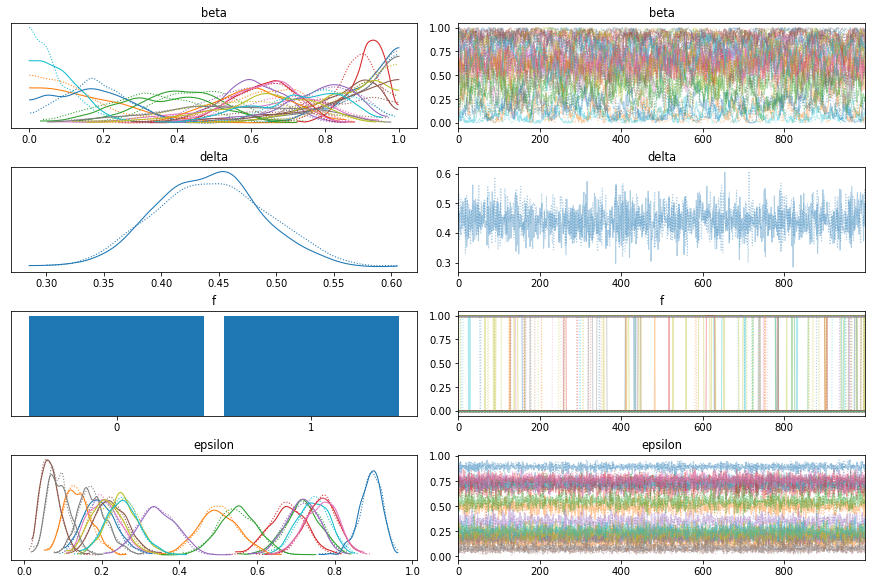

In [264]:
pm.traceplot(trace,var_names=["beta","delta","f","epsilon"]);

In [242]:
trace['delta'].mean()

0.4421892276331697

In [243]:
hidden_delta

0.3512355494942204

In [265]:
trace['epsilon']

0.4245300329268061

In [244]:
print(trace['beta'].mean(axis=0))
print(hidden_beta)

[0.89283702 0.14631981 0.43258268 0.89590561 0.58804162 0.83438561
 0.63614918 0.88652525 0.87235246 0.07964526 0.1747446  0.61834232
 0.34392017 0.62604359 0.7805043  0.78534801 0.6383671  0.5485854
 0.5994691  0.74881558]
[0.86583519 0.40446965 0.37147047 0.91689329 0.64265487 0.90750678
 0.72799183 0.73231331 0.43312468 0.07210774 0.22201181 0.65898232
 0.20605286 0.62742296 0.882989   0.41511239 0.69260092 0.78093816
 0.23401369 0.63131669]


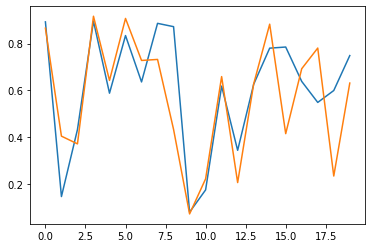

In [245]:
plot(trace['beta'].mean(axis=0))
plot(hidden_beta);

In [262]:
f_accuracy = (st.mode(trace['f'])[0].flatten()==hidden_f[:,0].flatten()).sum()/hidden_f.shape[0]

In [263]:
print(f_accuracy)

0.98


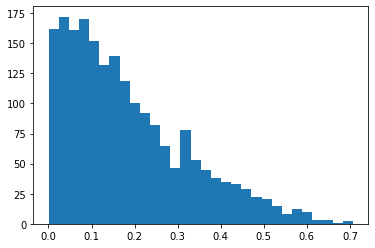

In [230]:
guessed_delta = trace['delta'].mean()
hist(trace['delta'],bins=30);